In [1]:
####################################################################################
#
# exmining_twins_and_supermag/non_twins_modeling_v0.py
#
# Performing the modeling using the Solar Wind and Ground Magnetomoeter data.
# TWINS data passes through a pre-trained autoencoder that reduces the TWINS maps
# to a reuced dimensionality. This data is then concatenated onto the model after
# both branches of the CNN hae been flattened, and before the dense layers.
# Similar model to Coughlan (2023) but with a different target variable.
#
####################################################################################


# Importing the libraries
import argparse
import datetime
import gc
import glob
import json
import math
import os
import pickle
import subprocess
import time

import matplotlib
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm
from scipy.special import expit, inv_boxcox
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from spacepy import pycdf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Dense, Dropout, Flatten, Input,
                                     MaxPooling2D, concatenate)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.backend import get_session

import utils

os.environ["CDF_LIB"] = "~/CDF/lib"

data_directory = '../../../../data/'
supermag_dir = '../data/supermag/feather_files/'
regions_dict = 'mike_working_dir/identifying_regions_data/identifying_regions_data/twins_era_identified_regions_min_2.pkl'
regions_stat_dict = 'mike_working_dir/identifying_regions_data/identifying_regions_data/twins_era_stats_dict_radius_regions_min_2.pkl'
working_dir = data_directory+'mike_working_dir/twins_data_modeling/'

random_seed = 7

2024-01-24 17:40:59.506582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
maps = utils.loading_twins_maps()

In [63]:
def getting_wedge(img_data, mlt_min: int = 18, mlt_max: int = 6, mlt_span: int=1, angle_steps: int = 8, center_x: int = 120, center_y: int = 80):
    """
    This function takes in a temperature ENA image and divides thems into pie slices based on the
    numbers of slices desired. The output of the function is an array of the mean different sections of the
    ENA temperature map generated and the different sections themselves, respectively.
    Parameters:
    -----------
    img_data : ndarray
        Input image data.
    mlt_min : int, optional
        Minimum MLT value. Default is 18.
    mlt_max : int, optional
        Maximum MLT value. Default is 6.
    mlt_span : int, optional
        MLT span. Default is 1.
    angle_steps : int, optional
        Number of angle steps for pie slices. Default is 8.
    center_x : int, optional
        X-coordinate of the center. Default is 120.
    center_y : int, optional
        Y-coordinate of the center. Default is 80.
    Returns:
    --------
    selected_sections : list
        List of selected pie slice sections.
    """
    # get the dimension of the image
    height, width = img_data.shape
    # Create an empty list to store the selected sections
    selected_sections = []
    img_mean = []
    # define the numbers of angles used for the pie slices
    N = int(360 / angle_steps)
    angles = [i+90 for i in range(0, 90, N)]
    # Create a duplicate of the angles for the other side of the image.
    angles.extend(angles)
    # Create masks for each N-degree section and apply them to the image
    for i, angle in enumerate(angles):
        # Create a new blank mask as a NumPy array
        mask = np.zeros((height, width), dtype=np.uint8)
        img_copy = np.copy(img_data)
        # Calculate the coordinates of the sector's bounding box
        start_angle = math.radians(angle)
        end_angle = math.radians(angle + N)
        # Calculate the coordinates of the sector arc
        for y in range(height):
            for x in range(width):
                # Calculate the polar coordinates of the pixel relative to the image center
                dx = x - center_x
                dy = center_y - y  # Flip the y-axis direction
                if i > ((angle_steps / 2) - 1):
                    dy = -dy
                pixel_angle = math.atan2(dy, dx)  # Calculate the angle in radians
                # Check if the pixel is within the current 45-degree section
                if start_angle <= pixel_angle < end_angle:
                    mask[y, x] = 1  # Set the pixel to white (255)
        # Apply the mask to the heat map to select the section
        img_copy[mask == 0] = 0
        # Append the selected section to the list
        selected_sections.append(img_copy)
        xx = np.copy(img_copy)
        xx[xx == 0] = np.nan
        # Get the mean of the non zero values of the image
        img_mean.append(np.nanmean(xx))
    return img_mean, selected_sections

[4.996015292804138, 7.4501795315368, 8.465816478040328, 10.560405330016321, 12.182809686089454, 4.996015292804138, 7.4501795315368, 8.465816478040328, 10.560405330016321, 12.182809686089454]


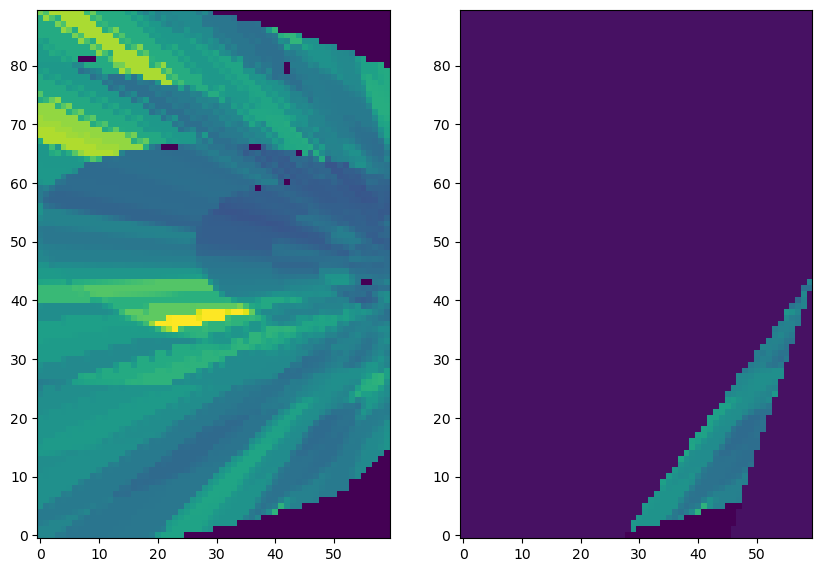

In [71]:
key = '2012-03-07 01:50:00'
img_mean, selected_sections = getting_wedge(maps[key]['map'], angle_steps=20, center_x=60, center_y=45)
print(img_mean)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
vmin = np.nanmin(maps[key]['map'])
vmax = np.nanmax(maps[key]['map'])
ax[0].imshow(maps[key]['map'], cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
ax[1].imshow(selected_sections[6], cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
plt.show()